In [50]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# PyTorch 출력 형식 조정
torch.set_printoptions(precision=8, threshold=10000, edgeitems=3)

In [51]:
file_path = "C:/Users/jhh88/Downloads/wiset_train_data_20240329-20240513.xlsx"
file_path1 = "C:/Users/jhh88/Downloads/wiset_test_data_20240407.xlsx"

df = pd.read_excel(file_path)
df1 = pd.read_excel(file_path1)

# 데이터프레임의 모든 object 타입 열을 숫자로 변환
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# 데이터프레임의 모든 object 타입 열을 숫자로 변환
for col in df1.select_dtypes(include=['object']).columns:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')

In [52]:
# 결측값을 0으로 대체 (또는 다른 방법으로 처리)
df.fillna(0, inplace=True)
df1.fillna(0, inplace=True)

# 변환된 결과 타입 확인
#print("After conversion:")
#print(df.dtypes)

# 변환된 데이터 확인
#print("Converted DataFrame:")
#print(df.head())

# 'datetime' 열을 제외한 나머지 열을 numpy 배열로 변환
train = df.drop(columns=['datetime']).to_numpy()
test = df1.drop(columns=['datetime']).to_numpy()

#print(test)

In [53]:
# PyTorch 출력 형식 조정
torch.set_printoptions(precision=8, threshold=10000, edgeitems=3)

# 데이터 정규화 (Min-Max Scaling)
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

# 첫 5개 열을 입력 데이터로 사용
x_train = torch.FloatTensor(train[:, :5])
x_test = torch.FloatTensor(test[:, :5])

# 나머지 열을 출력 데이터로 사용
y_train = torch.FloatTensor(train[:, 5:])
y_test = torch.FloatTensor(test[:, 5:])

#print(x_train)
#print(x_test)
#print(y_train)
#print(y_test)

In [54]:
# 모델 정의 (복잡도 증가 및 드롭아웃 추가)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5, 20)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(20, 10)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(10, 6)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [55]:
#model = nn.Linear(5,6)
model = SimpleNN()
#print(model)

#print(list(model.parameters()))

In [56]:
# 학습률(lr): 한 번 움직이는 거리
# Adam 옵티마이저 사용 (SGD 대신)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)  # L2 정규화 추가

# 조기 종료 설정
early_stopping_patience = 10
best_test_loss = float('inf')
epochs_no_improve = 0

#학습
epochs = 1000
train_score = []
test_score = []

for epoch in range(epochs + 1):
    model.train()
    # 순방향 전파
    y_pred = model(x_train)
    loss = nn.MSELoss()(y_pred, y_train)
    optimizer.zero_grad() #gradient를 초기화
    loss.backward() # 역전파: 미분값을 정하고 방향을 찾은 다음 주어진 lr만큼 이동하며 얻은 기울기와 절편을 계산
    optimizer.step()
    
    train_score.append(loss.item())
    
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            y_test_pred = model(x_test)
            test_loss = nn.MSELoss()(y_test_pred, y_test)
            test_score.append(test_loss.item())
            print(f'Epoch {epoch}/{epochs} Train Loss: {loss.item():.6f} Test Loss: {test_loss.item():.6f}')
            
            # 조기 종료 확인
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    print("Early stopping triggered")
                    break
                    
        model.train()

Epoch 0/1000 Train Loss: 0.185212 Test Loss: 0.252737
Epoch 100/1000 Train Loss: 0.016761 Test Loss: 0.015435
Epoch 200/1000 Train Loss: 0.012057 Test Loss: 0.007817
Epoch 300/1000 Train Loss: 0.011379 Test Loss: 0.007729
Epoch 400/1000 Train Loss: 0.010980 Test Loss: 0.007689
Epoch 500/1000 Train Loss: 0.010598 Test Loss: 0.006127
Epoch 600/1000 Train Loss: 0.010377 Test Loss: 0.006277
Epoch 700/1000 Train Loss: 0.010506 Test Loss: 0.007175
Epoch 800/1000 Train Loss: 0.010473 Test Loss: 0.006179
Epoch 900/1000 Train Loss: 0.010343 Test Loss: 0.005982
Epoch 1000/1000 Train Loss: 0.010168 Test Loss: 0.006448


In [61]:
# 테스트 데이터로 모델 평가
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)
    test_loss = nn.MSELoss()(y_test_pred, y_test)
    #test_score.append(test_loss.item())
    print(f'Test Loss: {test_loss.item():.6f}')
    


Test Loss: 0.006448


In [62]:
# 모델 평가 지표
# MeanSquared Error : 값이 낮을수록 예측값 = 실제 값
mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())

# R^2 Sccre : 1에 가까울수록 모델이 데이터를 잘 설명함
r2 = r2_score(y_test.numpy(), y_test_pred.numpy())

# Mean Absolute Error : 평균 절대 오차. 
# 값이 낮으면 모델이 대부분의 경우에 정확한 예측을 한다는 뜻
mae = mean_absolute_error(y_test.numpy(), y_test_pred.numpy())

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.006448435131460428
R^2 Score: 0.900275080503197
Mean Absolute Error: 0.06330730766057968


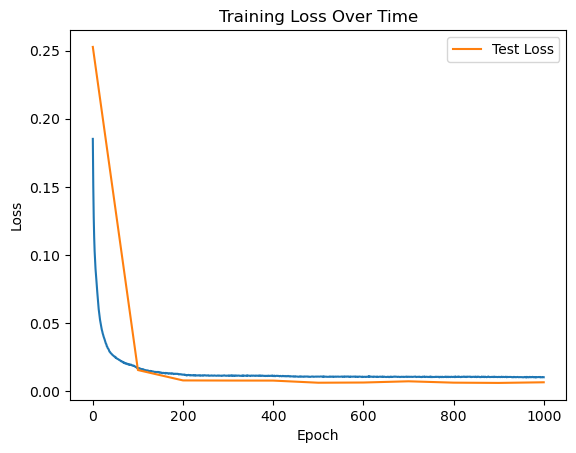

In [63]:
# 손실 값 시각화
plt.plot(train_score)
plt.plot(np.arange(0, len(test_score) * 100, 100), test_score, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()